학교급과 학년(초등학교 3~6학년, 중학교 1~5학년, 고등학교 1학년)을 예측하는 모델

- 학습목표
    - 한국어 텍스트 데이터 전처리, 특징 추출(WorldCloud)
    - 텍스트 백터화
    - 하이퍼파라미터 튜닝
- 데이터 출처
    - AI Hub - 수학 교과 문제 풀이과정 데이터

- 데이터셋에서 사용할 컬럼
    - school : 학교급 (초중고)
    - grade : 학년(3~6,1~3,1)
    - text_description : 수학 문제의 텍스트 설명
- target(class)
    - 총 8개의 클래스
        - 초등학교 3~6학년, 중학교 1~3학년, 고등학교 1학년

- 목차
    - 라이브러리 설정 및 데이터 불러오기
    - 탐색적 데이터 분석 (EDA)
    - 텍스트 데이터 전처리
    - 특징 추출 및 백터화
    - 모델 구현 및 학습
    - 모델 성능 평가 및 해석
    - 하이퍼파리미터 튜닝

## 1. 라이브러리 설정 및 데이터 불러오기

In [90]:
# 기본 라이브러리
import pandas as pd
import numpy as np

# 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rcParams['font.family'] = 'AppleGothic'

# 텍스트 전처리
import re                               # 텍스트 패턴 처리 (정규표현식)
from collections import Counter         # 단어 출현 빈도수 세는 용도

# 텍스트 파싱 및 머신러닝 라이브러리
from bs4 import BeautifulSoup           # HTML 태그 등 텍스트 전처리용
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score     # 데이터분할, 하이퍼파라미터 최적화, 
from sklearn.preprocessing import LabelEncoder # 레이블(문자+숫자)인코딩

# 머신러닝 라이브러리
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB   # 다항분포 나이브베이즈 모델
from sklearn.metrics import(
    accuracy_score,                 # 정확도
    precision_score,                # 정밀도
    recall_score,                   # 재현율
    f1_score,                 # F1 스코어
    classification_report,          # 분류 평가 보고서
    confusion_matrix                # 혼동행렬 지표
    
)


# 경고메시지 숨김용
import warnings
warnings.filterwarnings('ignore')
print('라이브러리 임포트 완료')

라이브러리 임포트 완료


In [91]:
train_df = pd.read_csv("data/school_train.csv")
train_df.head()

,school,grade,text_descriptions
0,초등학교,3학년,계산 결과가 3000보다 큰 곱셈식을 모두 선택하세요.\n첫 번째 집: $80 \t...
1,초등학교,3학년,색칠된 부분은 실제 어떤 수의 곱인지 찾아 선택하세요.\n$3\times4$ $30...
2,초등학교,3학년,$\square$ 안의 수가 다른 하나를 찾아 기호를 선택해보세요.\n㉠ $60 \...
3,초등학교,3학년,계산 결과가 큰 것부터 순서대로 나열한 것을 고르세요.\n$4 \times 28$\...
4,초등학교,3학년,색칠된 부분은 실제 어떤 수의 곱인지를 찾아 선택하세요.\n\[ \begin{arr...


In [92]:
test_df = pd.read_csv("data/school_test.csv")
test_df.head()

,school,grade,text_descriptions
0,초등학교,3학년,가방 $80$개를 $4$개의 상자에 똑같이 나누어 담았습니다. 상자 한 개에 담은 ...
1,초등학교,3학년,학생 $120$명이 체육대회에 참여했습니다. $600$개의 장난감을 학생들에게 똑같...
2,초등학교,3학년,사탕 225개를 15개의 박스에 똑같이 나누어 담았습니다. 박스 한 개에 담은 사탕...
3,초등학교,3학년,도서관에 책 $270$권이 있습니다. 이 책을 $9$개의 책꽂이에 똑같이 나누어 놓...
4,초등학교,3학년,기차 8대에 320명의 승객이 탑승했습니다. 기차 한 대에 탑승한 승객은 몇 명일까요?


In [93]:
print(f"학습 데이터: {train_df.shape[0]}개 데이터, {train_df.shape[1]}개 컬럼")
print(f"테스트 데이터: {test_df.shape[0]}개 데이터, {test_df.shape[1]}개 컬럼")

train_df.columns.to_list()

학습 데이터: 16248개 데이터, 3개 컬럼
테스트 데이터: 2032개 데이터, 3개 컬럼


['school', 'grade', 'text_descriptions']

# 탐색적 데이터 분석 (EDA)

In [94]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16248 entries, 0 to 16247
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   school             16248 non-null  object
 1   grade              16248 non-null  object
 2   text_descriptions  16248 non-null  object
dtypes: object(3)
memory usage: 380.9+ KB


In [95]:
train_df.isna().sum()

school               0
grade                0
text_descriptions    0
dtype: int64

In [96]:
test_df.isnull().sum()

school               0
grade                0
text_descriptions    0
dtype: int64

In [97]:
# train_df.fillna()
# train_df.dropna()

# 만약 결측치가 test_descriptions 컬럼의 결측치 행을 제거하고싶다면
# train_df.dropna(subset=['text_descriptions'],inplace=True)

In [98]:
train_df['grade']

0        3학년
1        3학년
2        3학년
3        3학년
4        3학년
        ... 
16243    1학년
16244    1학년
16245    1학년
16246    1학년
16247    1학년
Name: grade, Length: 16248, dtype: object

In [99]:
train_df['school_grade'] = train_df['school'] +' ' + train_df['grade']


[Text(0, 0, '고등\n1학년'),
 Text(1, 0, '초등\n3학년'),
 Text(2, 0, '초등\n4학년'),
 Text(3, 0, '초등\n5학년'),
 Text(4, 0, '초등\n6학년'),
 Text(5, 0, '중\n3학년'),
 Text(6, 0, '중\n1학년'),
 Text(7, 0, '중\n2학년')]

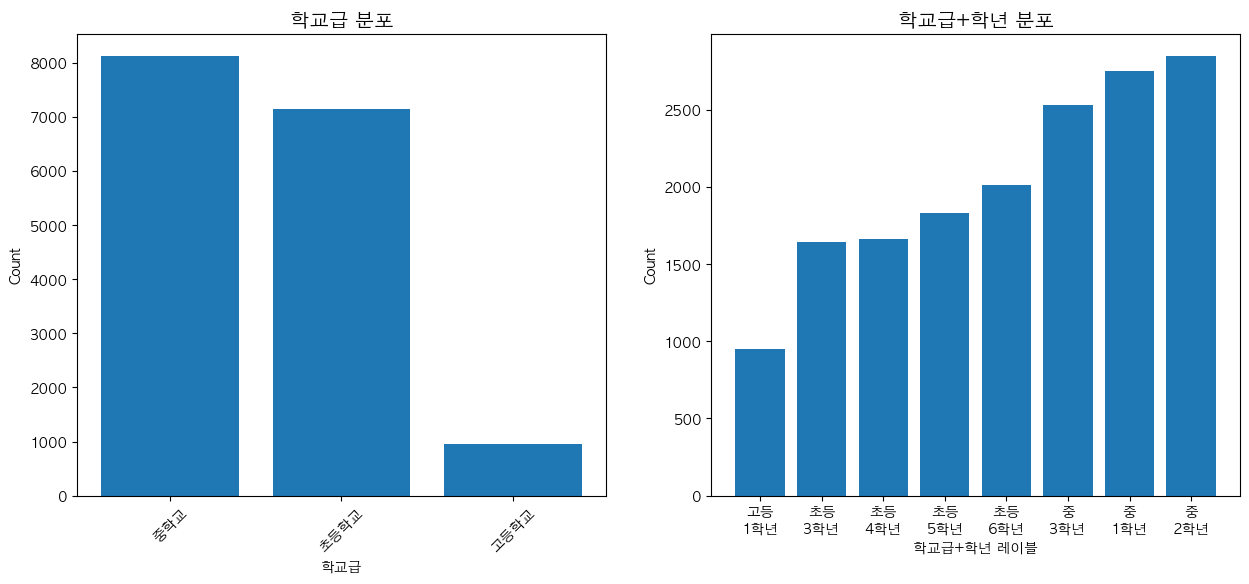

In [100]:
# 타겟 변수 분포 시각화
fig, axes = plt.subplots(1,2,figsize=(15,6))

# 학교급 분포 (예: 초중고)
school_counts = train_df['school'].value_counts()

axes[0].bar(school_counts.index, school_counts.values)      # 막대 그래프
axes[0].set_title("학교급 분포", fontsize=14)
axes[0].set_xlabel('학교급')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x',rotation=45)   # x축 라벨 설정

# 학교급-학년 조합 분포 (예: 초3, 중2, 고1)

school_grade_counts = train_df['school_grade'].value_counts().sort_values()

axes[1].bar(school_grade_counts.index, school_grade_counts.values)      # 막대 그래프
axes[1].set_title("학교급+학년 분포", fontsize=14)
axes[1].set_xlabel('학교급+학년 레이블')
axes[1].set_ylabel('Count')
axes[1].set_xticks(range(len(school_grade_counts))) # x축 눈금 설정
axes[1].set_xticklabels([sg.replace('학교','').replace(' ','\n') for sg in school_grade_counts.index], rotation=0)


고등학교 문제를 잘 못 맞출

In [101]:
# 클래스 불균형 분석

class_ratio = school_grade_counts / school_grade_counts.sum() * 100 # 각 클래스가 전체에서 차지하는 비율 계산 
for class_name, ratio, in class_ratio.items():
    print(f"{class_name}: {ratio:.2f}%")

imbalance_ratio = school_grade_counts.max() / school_grade_counts.min()
print(f"최대/최소 클래스 비율 : {imbalance_ratio:.2f}")


고등학교 1학년: 5.86%
초등학교 3학년: 10.14%
초등학교 4학년: 10.25%
초등학교 5학년: 11.27%
초등학교 6학년: 12.40%
중학교 3학년: 15.58%
중학교 1학년: 16.95%
중학교 2학년: 17.57%
최대/최소 클래스 비율 : 3.00


고등학교 문제가 적다!

텍스트 데이터 분석

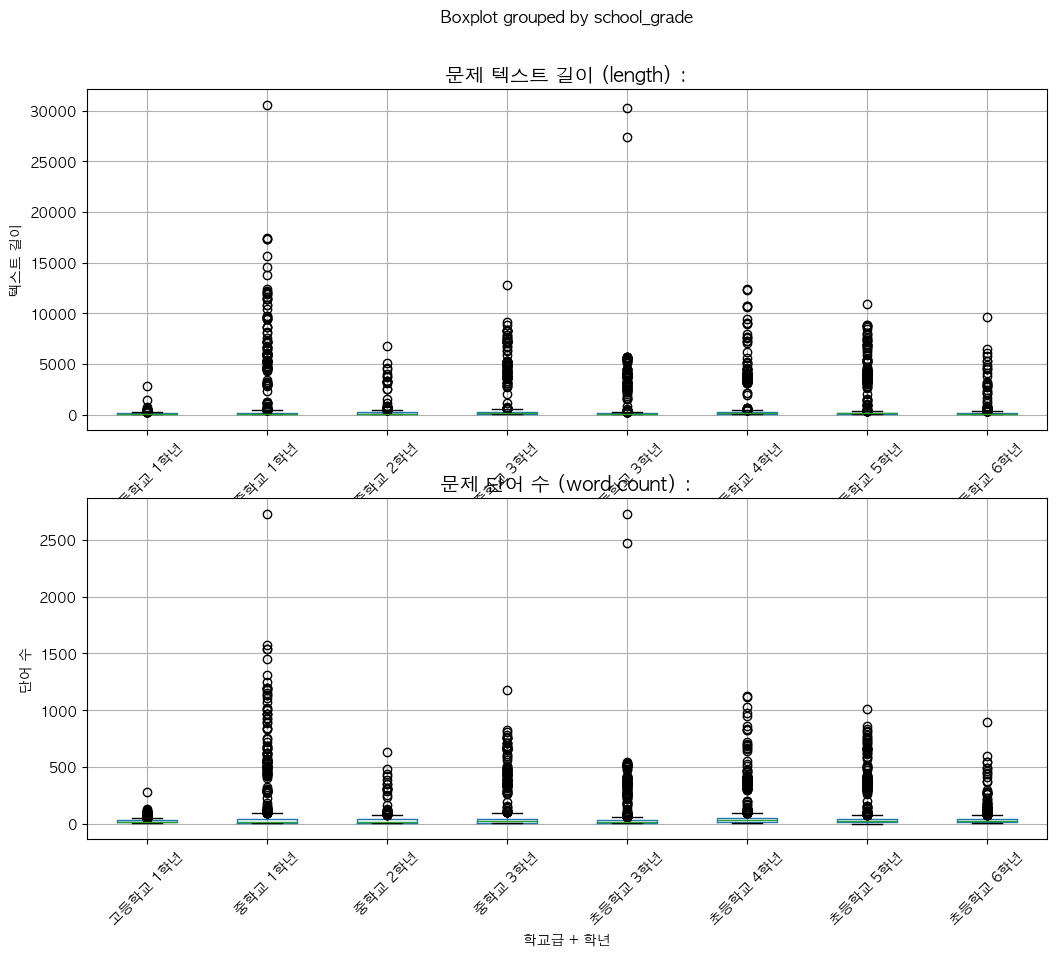

In [102]:
# 텍스트 길이 및 단어 수 분석
train_df['text_length'] = train_df['text_descriptions'].str.len()   # 텍스트(문제) 글자 수
train_df['word_count'] = train_df['text_descriptions'].str.split().str.len()   # 텍스트(문제) 글자내 단어  수

# 학교급별 텍스트 길이 분포
fig, axes = plt.subplots(2,1,figsize=(12,10))
train_df.boxplot(column='text_length', by='school_grade', ax=axes[0])
axes[0].set_title('문제 텍스트 길이 (length) :', fontsize=14)
axes[0].set_xlabel("학교급 + 학년")
axes[0].set_ylabel("텍스트 길이")
axes[0].tick_params(axis='x',rotation=45)

# 단어 수 박스플롯
train_df.boxplot(column='word_count', by='school_grade', ax=axes[1])
axes[1].set_title('문제 단어 수 (word count) :', fontsize=14)
axes[1].set_xlabel("학교급 + 학년")
axes[1].set_ylabel("단어 수")
axes[1].tick_params(axis='x',rotation=45)

텍스트 기준 1000자, 단어 수 200개 글자 정도안에 들어와야 정상일 것으로 보인다. 이상치 처리가 필요하다.

In [103]:
train_df[train_df['text_length']>=1000]['text_descriptions'].iloc[0]

'지름을 나타내는 선분을 찾아 길이를 잰 값을 보고, 맞는 말을 선택해 보 세요.\n한 원에서 원의 지름은 모두 (같습니다, 다릅니다).\n정원형이 있고 중심에는 ㅇ 가 있습니다. 점 ㅇ와 연결된 꼭짓점 (ㄷ, ㅅ, ㄴ, ㄷ, ㄹ, ㅁ, ㅂ)가 있습니다.\n<div class="table_tabular " style="text-align: center"> <div class="inline-tabular"><table id="tabular"> <tbody> <tr style="border-top: none !important; border-bottom: none !important;"> <td style="text-align: center; border-left: none !important; border-right-style: solid !important; border-right-width: 1px !important; border-bottom-style: solid !important; border-bottom-width: 1px !important; border-top-style: solid !important; border-top-width: 1px !important; width: auto; vertical-align: middle; ">지름</td> <td style="text-align: center; border-right-style: solid !important; border-right-width: 1px !important; border-bottom-style: solid !important; border-bottom-width: 1px !important; border-top-style: solid !important; border-top-width: 1px !important; width: auto; vertical-align: middle; ">선분 ㄱㅁ</td> <td style="text-align: center; border-ri

html 태그가 들어있다. 삭제가 필요한 부분이라 판단된다.

In [104]:
def remove_html_tags(text):
    return BeautifulSoup(text,'html.parser').get_text()

train_df['text_descriptions_clean'] = train_df['text_descriptions'].apply(remove_html_tags)

train_df[train_df['text_length']>=1000]['text_descriptions_clean'].iloc[0]

'지름을 나타내는 선분을 찾아 길이를 잰 값을 보고, 맞는 말을 선택해 보 세요.\n한 원에서 원의 지름은 모두 (같습니다, 다릅니다).\n정원형이 있고 중심에는 ㅇ 가 있습니다. 점 ㅇ와 연결된 꼭짓점 (ㄷ, ㅅ, ㄴ, ㄷ, ㄹ, ㅁ, ㅂ)가 있습니다.\n    지름 선분 ㄱㅁ 선분 ㄴㅂ 선분 ㄹㅅ   길이  $(\\mathrm{cm})$ 3 3 3    '

In [105]:
train_df['text_descriptions'] = train_df['text_descriptions_clean']
train_df.drop(columns=['text_descriptions_clean'],inplace=True)

In [106]:
train_df

,school,grade,text_descriptions,school_grade,text_length,word_count
0,초등학교,3학년,계산 결과가 3000보다 큰 곱셈식을 모두 선택하세요.\n첫 번째 집: $80 \t...,초등학교 3학년,122,31
1,초등학교,3학년,색칠된 부분은 실제 어떤 수의 곱인지 찾아 선택하세요.\n$3\times4$ $30...,초등학교 3학년,101,21
2,초등학교,3학년,$\square$ 안의 수가 다른 하나를 찾아 기호를 선택해보세요.\n㉠ $60 \...,초등학교 3학년,130,26
3,초등학교,3학년,계산 결과가 큰 것부터 순서대로 나열한 것을 고르세요.\n$4 \times 28$\...,초등학교 3학년,72,17
4,초등학교,3학년,색칠된 부분은 실제 어떤 수의 곱인지를 찾아 선택하세요.\n\[ \begin{arr...,초등학교 3학년,248,50
...,...,...,...,...,...,...
16243,고등학교,1학년,유리함수 $y=\frac{x+a}{b x+c}$의 그래프가 오른쪽 그림과 같고이 그...,고등학교 1학년,272,56
16244,고등학교,1학년,유리함수 $y=\frac{k x}{x+3}$의 그래프가 직선 $y=x$에 대하여 대...,고등학교 1학년,68,13
16245,고등학교,1학년,분모를 0으로 하지 않는 모든 실수 $x$에 대하여 등식 \[ \begin{arra...,고등학교 1학년,210,28
16246,고등학교,1학년,오른쪽 그림과 같이 유리 함수 $y=\frac{9}{x}+2(x>0)$의 그래프 위...,고등학교 1학년,271,38


In [107]:
test_df['text_descriptions_clean'] = test_df['text_descriptions'].apply(remove_html_tags)
test_df['text_descriptions'] = test_df['text_descriptions_clean']
test_df.drop(columns=['text_descriptions_clean'],inplace=True)

test_df

,school,grade,text_descriptions
0,초등학교,3학년,가방 $80$개를 $4$개의 상자에 똑같이 나누어 담았습니다. 상자 한 개에 담은 ...
1,초등학교,3학년,학생 $120$명이 체육대회에 참여했습니다. $600$개의 장난감을 학생들에게 똑같...
2,초등학교,3학년,사탕 225개를 15개의 박스에 똑같이 나누어 담았습니다. 박스 한 개에 담은 사탕...
3,초등학교,3학년,도서관에 책 $270$권이 있습니다. 이 책을 $9$개의 책꽂이에 똑같이 나누어 놓...
4,초등학교,3학년,기차 8대에 320명의 승객이 탑승했습니다. 기차 한 대에 탑승한 승객은 몇 명일까요?
...,...,...,...
2027,고등학교,1학년,6명의 학생을 다음과 같이 3개의 조로 나누는 모든 방법의 수를 구하시오.\n① 1...
2028,고등학교,1학년,"A, B, C, A의 네 지점이 오른쪽 그림과 같이 서로 여러 개의 길로 연결되어 ..."
2029,고등학교,1학년,"오른쪽 그림과 같이 평행한 두 직선 $l$, $m$ 위에 점이 각각 $3$개, $4..."
2030,고등학교,1학년,"오른쪽 그림과 같이 삼각형 위에 서로 다른 9개의 점 $\mathrm{A}_{1},..."


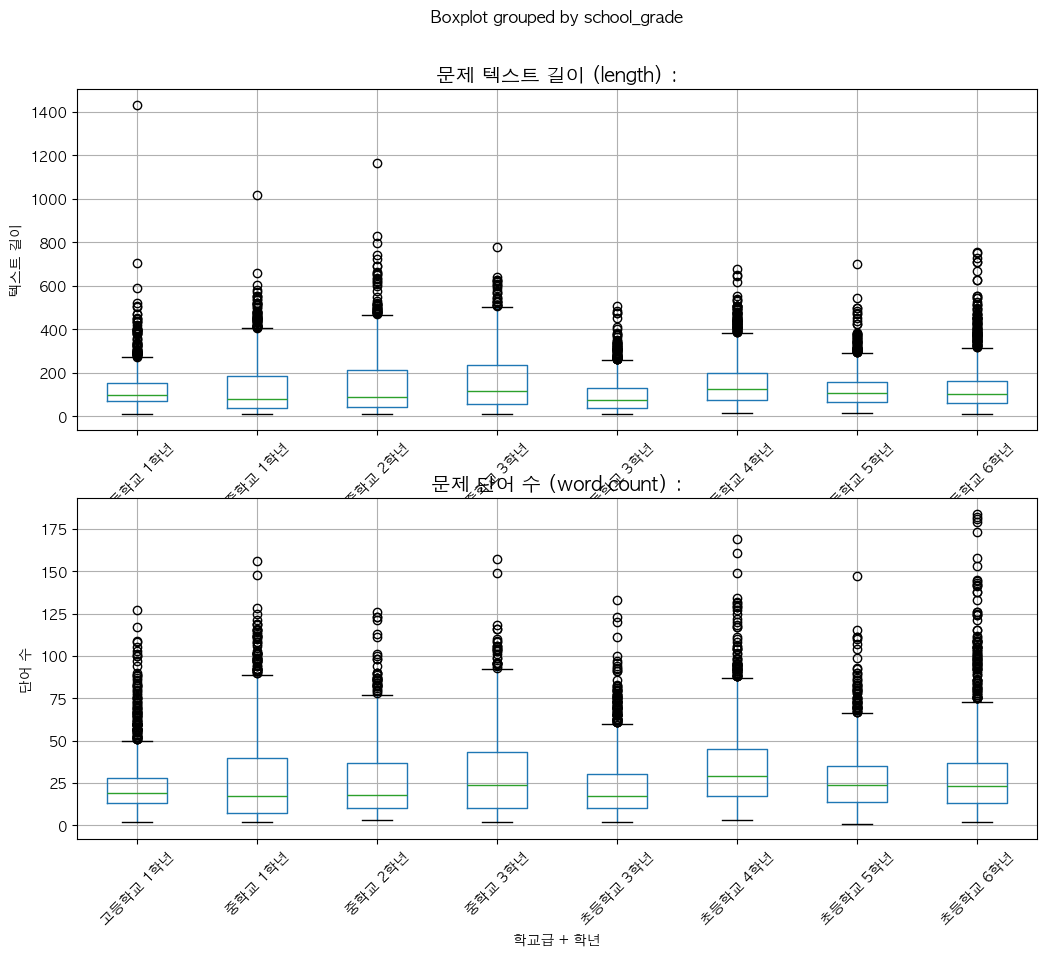

In [108]:
# 텍스트 길이 및 단어 수 분석
train_df['text_length'] = train_df['text_descriptions'].str.len()               # 텍스트(문제) 글자 수
train_df['word_count'] = train_df['text_descriptions'].str.split().str.len()    # 텍스트(문제) 글자내 단어  수

# 학교급별 텍스트 길이 분포
fig, axes = plt.subplots(2,1,figsize=(12,10))
train_df.boxplot(column='text_length', by='school_grade', ax=axes[0])
axes[0].set_title('문제 텍스트 길이 (length) :', fontsize=14)
axes[0].set_xlabel("학교급 + 학년")
axes[0].set_ylabel("텍스트 길이")
axes[0].tick_params(axis='x',rotation=45)

# 단어 수 박스플롯
train_df.boxplot(column='word_count', by='school_grade', ax=axes[1])
axes[1].set_title('문제 단어 수 (word count) :', fontsize=14)
axes[1].set_xlabel("학교급 + 학년")
axes[1].set_ylabel("단어 수")
axes[1].tick_params(axis='x',rotation=45)

학년이 올라갈수록 길이가 길어진다. 하지만 고등학교는 표본수가 적어서 구별하기가 애매할 수 있다.

In [109]:
# 학년별 텍스트 길이 및 단어 수의 평균, 표준편차 집계
text_stats = train_df.groupby('school_grade')[['text_length','word_count']].agg(['mean','std'])
print(text_stats.round(2))

             text_length         word_count       
                    mean     std       mean    std
school_grade                                      
고등학교 1학년          126.61   97.75      24.32  19.22
중학교 1학년           122.35  109.35      26.00  23.96
중학교 2학년           140.89  124.45      24.80  18.71
중학교 3학년           155.97  121.82      28.47  21.59
초등학교 3학년           95.26   74.83      22.63  18.22
초등학교 4학년          150.23  104.93      34.43  23.83
초등학교 5학년          121.03   76.15      27.02  17.54
초등학교 6학년          125.24   96.21      29.02  23.82


학교급과 학년별로는 글자수와 문장수로 판단이 될만한 요소는 있지만, 고등학교가 애매하다.
그래서 특징으로 자주 나오는 단어등을 같이 추가를 해줘야 정확한 겨과를 얻을 수 있을 것으로 판단이 된다.

In [110]:
# train_df[train_df['school_grade'] == grade]['text_descriptions'].tolist()

In [111]:
# 학년별 특징적인 단어 추출 (상위 10개)
for grade in train_df['school_grade'].unique():
    # 학년별 하나의 문자열로 text_descriptions를 묶어준다.
    grade_texts = " ".join(train_df[train_df['school_grade'] == grade]['text_descriptions'].tolist())

    # 한글 단어만 추출
    words = re.findall(r"[가-힣]+", grade_texts)
    word_counts = Counter(words)

    # 조사 삭제 (예) 에, 의, 를 ...)
    stopwords = ["의", "를", "을", "과", "에", "는", "이", "가", "하고", "에서", "으로", "로", "와", "$" ]
    for sw in stopwords:
        word_counts.pop(sw, None)
    print(grade)
    for word, count in word_counts.most_common(10): # 상위 10개 단어
        print(f"{word}: {count}회")
        

초등학교 3학년
있습니다: 461회
선택하세요: 453회
모두: 311회
수: 299회
있다: 298회
두: 291회
것을: 271회
큰: 269회
몇: 245회
가장: 238회
초등학교 4학년
있습니다: 882회
선택하세요: 754회
있다: 473회
것을: 461회
수: 450회
두: 397회
나타낸: 397회
있는: 340회
알맞은: 328회
찾아: 315회
초등학교 5학년
보세요: 961회
있다: 542회
것을: 482회
찾아: 443회
선택하세요: 400회
수: 394회
선택해: 359회
있습니다: 348회
모두: 328회
두: 324회
초등학교 6학년
보세요: 1207회
있습니다: 771회
개: 629회
있다: 499회
선택해: 496회
본: 445회
모양을: 430회
개의: 415회
찾아: 405회
인: 385회
중학교 1학년
다음: 1139회
오른쪽: 908회
때: 851회
구하시오: 643회
있다: 626회
있습니다: 597회
두: 590회
점: 553회
중: 513회
계산하시오: 484회
중학교 2학년
때: 1422회
다음: 1237회
점: 1065회
오른쪽: 970회
구하시오: 883회
일: 866회
삼각형: 667회
길이는: 652회
있습니다: 651회
그림과: 604회
중학교 3학년
점: 1346회
때: 1168회
오른쪽: 1099회
있습니다: 1076회
다음: 836회
일: 785회
원: 736회
길이는: 692회
각: 632회
있다: 568회
고등학교 1학년
때: 530회
구하시오: 477회
두: 325회
대하여: 306회
값을: 300회
점: 293회
다음: 244회
일: 199회
실수: 148회
집합: 140회


In [112]:
word_counts.most_common(10)

[('때', 530),
 ('구하시오', 477),
 ('두', 325),
 ('대하여', 306),
 ('값을', 300),
 ('점', 293),
 ('다음', 244),
 ('일', 199),
 ('실수', 148),
 ('집합', 140)]

In [113]:
test_df['school_grade'] = test_df['school'] + ' ' + test_df['grade']
test_df

,school,grade,text_descriptions,school_grade
0,초등학교,3학년,가방 $80$개를 $4$개의 상자에 똑같이 나누어 담았습니다. 상자 한 개에 담은 ...,초등학교 3학년
1,초등학교,3학년,학생 $120$명이 체육대회에 참여했습니다. $600$개의 장난감을 학생들에게 똑같...,초등학교 3학년
2,초등학교,3학년,사탕 225개를 15개의 박스에 똑같이 나누어 담았습니다. 박스 한 개에 담은 사탕...,초등학교 3학년
3,초등학교,3학년,도서관에 책 $270$권이 있습니다. 이 책을 $9$개의 책꽂이에 똑같이 나누어 놓...,초등학교 3학년
4,초등학교,3학년,기차 8대에 320명의 승객이 탑승했습니다. 기차 한 대에 탑승한 승객은 몇 명일까요?,초등학교 3학년
...,...,...,...,...
2027,고등학교,1학년,6명의 학생을 다음과 같이 3개의 조로 나누는 모든 방법의 수를 구하시오.\n① 1...,고등학교 1학년
2028,고등학교,1학년,"A, B, C, A의 네 지점이 오른쪽 그림과 같이 서로 여러 개의 길로 연결되어 ...",고등학교 1학년
2029,고등학교,1학년,"오른쪽 그림과 같이 평행한 두 직선 $l$, $m$ 위에 점이 각각 $3$개, $4...",고등학교 1학년
2030,고등학교,1학년,"오른쪽 그림과 같이 삼각형 위에 서로 다른 9개의 점 $\mathrm{A}_{1},...",고등학교 1학년


In [114]:
train_df['school_grade'].unique()

array(['초등학교 3학년', '초등학교 4학년', '초등학교 5학년', '초등학교 6학년', '중학교 1학년',
       '중학교 2학년', '중학교 3학년', '고등학교 1학년'], dtype=object)

In [115]:
target_classes = sorted(train_df['school_grade'].unique())  # 타겟 클래스 목록 (오름차순 정렬)
# target_classes
for i, tc in enumerate(target_classes):
    print(f"{i}: {tc}")  # 클래스 번호와 클래스명 출력

0: 고등학교 1학년
1: 중학교 1학년
2: 중학교 2학년
3: 중학교 3학년
4: 초등학교 3학년
5: 초등학교 4학년
6: 초등학교 5학년
7: 초등학교 6학년


- 레이블 인코딩
    - 문자형 범주형 변수를 숫자로 변환 

In [116]:
# school_grade를 숫자형 타겟으로 변환

label_encoder = LabelEncoder()
train_df['target'] = label_encoder.fit_transform(train_df['school_grade'])  # 학습데이터 인코딩
test_df['target'] = label_encoder.transform(test_df['school_grade'])        # 테스트데이터 인코딩

train_df

,school,grade,text_descriptions,school_grade,text_length,word_count,target
0,초등학교,3학년,계산 결과가 3000보다 큰 곱셈식을 모두 선택하세요.\n첫 번째 집: $80 \t...,초등학교 3학년,122,31,4
1,초등학교,3학년,색칠된 부분은 실제 어떤 수의 곱인지 찾아 선택하세요.\n$3\times4$ $30...,초등학교 3학년,101,21,4
2,초등학교,3학년,$\square$ 안의 수가 다른 하나를 찾아 기호를 선택해보세요.\n㉠ $60 \...,초등학교 3학년,130,26,4
3,초등학교,3학년,계산 결과가 큰 것부터 순서대로 나열한 것을 고르세요.\n$4 \times 28$\...,초등학교 3학년,72,17,4
4,초등학교,3학년,색칠된 부분은 실제 어떤 수의 곱인지를 찾아 선택하세요.\n\[ \begin{arr...,초등학교 3학년,248,50,4
...,...,...,...,...,...,...,...
16243,고등학교,1학년,유리함수 $y=\frac{x+a}{b x+c}$의 그래프가 오른쪽 그림과 같고이 그...,고등학교 1학년,272,56,0
16244,고등학교,1학년,유리함수 $y=\frac{k x}{x+3}$의 그래프가 직선 $y=x$에 대하여 대...,고등학교 1학년,68,13,0
16245,고등학교,1학년,분모를 0으로 하지 않는 모든 실수 $x$에 대하여 등식 \[ \begin{arra...,고등학교 1학년,210,28,0
16246,고등학교,1학년,오른쪽 그림과 같이 유리 함수 $y=\frac{9}{x}+2(x>0)$의 그래프 위...,고등학교 1학년,271,38,0


### 4. 특징 추출 및 벡터화
- TF-ITF : 얼마나 자주 단어가 나오느냐(TF), 단어가 전체 문서 중 몇개 문서에 등장하는가 (IDF)
    - 하나의 문서에서 단어의 중요도를 빈도수(TF - Term Frequency)로 표현한다.
        - 전체 문서에서의 희귀도(IDF - Inverse Document Frequency)를 결합해서 측정하는 방식

In [117]:
tfidf_vectorizer = TfidfVectorizer(
    max_features = 1000, # 최대 feature 수 : 추출할 최대 단어 수
    min_df = 2,          # 최소 문서 빈도 : 최소 2개 문서에는 등장해야 feature로 사용
    max_df = 0.8,        # 최대 문서 빈도 : 전체 문서 중 80% 이하에서 등장하는 단어만 사용
    ngram_range=(1, 3),  # 1~3 단어 조합까지 벡터화 (unigram, bigram, trigram)
    sublinear_tf = True, # tf 값에 log 적용: 빈도수에 log 스케일 적용
    use_idf = True       # IDF 값 사용
)

# 학습 데이터로 벡터라이저 학습 및 변환 (문자 -> 벡터)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['text_descriptions'])

# 테스트 데이터로 벡터라이저 학습데이터와 동일한 기준으로 변환 (문자 -> 벡터)
X_test_tfidf = tfidf_vectorizer.transform(test_df['text_descriptions'])

print(f"train : {X_train_tfidf.shape}")
print(f"test : {X_test_tfidf.shape}")


train : (16248, 1000)
test : (2032, 1000)


- CounterVectorizer 
    - 텍스트 데이터를 숫자 벡터로 변환할 때 가장 기본적인 방식.
    - 각 문서에 어떤 단어가 몇번 등장했는지 세어주는 도구.

In [118]:
# CountVectorizer 객체 생성 (파라미터는 TF-IDF와 동일, 단어 빈도수 벡터화)
count_vectorizer = CountVectorizer(
    max_features = 1000,
    min_df = 2,
    max_df = 0.8,
    ngram_range = (1, 3)
)

X_train_count = count_vectorizer.fit_transform(train_df['text_descriptions'])
X_test_count = count_vectorizer.transform(test_df['text_descriptions'])

print(f"train : {X_train_count.shape}")
print(f"test : {X_test_count.shape}")

train : (16248, 1000)
test : (2032, 1000)


- 추가 특징 생성
    - 텍스트 길이
    - 수학 기호, 숫자 관련 특징
    - 특정 키워드 포함 여부
    - 문장 복잡도
    - 괄호 사용

- 정규표현식
    - \ : 약속된 표현 
    - d 만 사용 하는 경우 : 문자
    - \d : 숫자 1개
    - \d+ : 숫자 여러개
    - \w :  문자 + 숫자 + _
    - \s :  공백
    - \D :  숫자가 아닌 것
    - r (raw string): 문자 그대로

In [119]:
# 추가 특집 생성 함수

def extract_additional_features(df):

    features = pd.DataFrame()

    # 1. 텍스트 길이, 단어 수, 평균 단어 길이
    features['text_length'] = df['text_descriptions'].str.len()  # 전체 글자 수
    features['word_count'] = df['text_descriptions'].str.split().str.len()  # 단어 수
    features['avg_word_length'] = features['text_length'] / (features['word_count'] + 1)  # 평균 단어 길이

    # 2. 수학기호, 숫자관련 특징 패턴 추출
    features['num_count'] = df['text_descriptions'].str.count(r'\d+')  # 숫자 등장 횟수
    features['has_fraction'] = df['text_descriptions'].str.contains(r'\d+/\d+').astype(int)  # 분수 포함 여부(0, 1)
    features['has_decimal'] = df['text_descriptions'].str.contains(r'\d+\.\d+').astype(int)  # 소수 포함 여부 (0, 1)
    features['math_symbol_count'] = df['text_descriptions'].str.count(r'[+\-×÷=]')           # 수학 기호 등장 횟수

    # 3. 특정 키워드 포함 여부
    features['has_geometry'] = df['text_descriptions'].str.contains(r'도형|삼각형|사각형|원|직사각형|정사각형').astype(int) # 도형 포함 여부
    features['has_measurement'] = df['text_descriptions'].str.contains(r'길이|넓이|부피|무게|시간').astype(int)         # 단위 포함 여부
    features['has_calculation'] = df['text_descriptions'].str.contains(r'계산|구하|얼마').astype(int)                # 계산 포함 여부
    features['has_comparison'] = df['text_descriptions'].str.contains(r'크다|작다|같다|많다|적다').astype(int)         # 비교 포함 여부

    # 4. 문장 구조 관련 특징
    features['sentence_count'] = df['text_descriptions'].str.count(r'[.!?]') + 1 # 문장 수 갯수 (구분기호 수 + 1)
    features['question_count'] = df['text_descriptions'].str.count(r'\?') # 질문 문장 갯수 (물음표 갯수)

    # 5. 괄호 사용
    features['parenthesis_count'] = df['text_descriptions'].str.count(r'[()\[\]]') # 괄호 등장 횟수

    return features # 14개의 파생변수를 가지고 있는 df반환

# 추가 특징 추출 함수 적용
train_features = extract_additional_features(train_df)
test_features = extract_additional_features(test_df)

# 결측값은 0으로 채운다
train_features = train_features.fillna(0)
test_features = test_features.fillna(0)

print(f"추가 특징 개수 : {train_features.shape[1]}")
print(f"추가 특징 컬럼 : {list(train_features.columns)}")

추가 특징 개수 : 14
추가 특징 컬럼 : ['text_length', 'word_count', 'avg_word_length', 'num_count', 'has_fraction', 'has_decimal', 'math_symbol_count', 'has_geometry', 'has_measurement', 'has_calculation', 'has_comparison', 'sentence_count', 'question_count', 'parenthesis_count']


In [120]:
from scipy.sparse import hstack

X_train_combined = hstack([X_train_tfidf, train_features])
X_test_combined = hstack([X_test_tfidf, test_features])

print(f"Train Shape: {X_train_combined.shape}")
print(f"Test Shape: {X_test_combined.shape}")

Train Shape: (16248, 1014)
Test Shape: (2032, 1014)


### 5. 모델 구현 및 학습
- 기본 모델 학습

In [121]:
# 타겟 변수 준비
y_train = train_df['target']
y_test = test_df['target']

In [122]:
models = {
    "Logistic Regression" : LogisticRegression(
        max_iter=1000,   # 최대 반복 횟수
        random_state=42  # 랜덤시드 (재현성)
    ),
    "Random Forest" : RandomForestClassifier(
        n_estimators=100,  # 의사결정 트리 갯수
        random_state=42    # 랜덤시드
    ),
    "Naive Bayes" : MultinomialNB(),  # 다항부포 나이브베이즈
}

results = {} # 모델 학습 및 평가 결과 저장

In [123]:
for name, model in models.items():
    print(f"{name} 학습 중입니다.")

    if name == "Naivce Bayes":
        # Naive Bayes는 음수를 처리할 수 없다. 추가변수를 사용하지 않고 TF-IDF만 사용 (1000개의 컬럼만 사용)
        model.fit(X_train_tfidf, y_train)
        train_pred = model.predict(X_train_tfidf) # 학습데이터 예측
        test_pred = model.predict(X_test_tfidf)   # 테스트데이터 예측

    else:
        # 그 외 모델들은 음수 처리 가능하기 때문에 TF-IDF변수 + 추가변수 사용가능하다. (1014개의 컬러 사용)
        model.fit(X_train_combined, y_train)
        train_pred = model.predict(X_train_combined) # 학습데이터 예측
        test_pred = model.predict(X_test_combined)   # 테스트데이터 예측

    # 성능평가 (정확도, F1-Score)
    train_acc = accuracy_score(y_train, train_pred) # 학습 데이터 정확도
    test_acc = accuracy_score(y_test, test_pred)    # 테스트 데이터 정확도
    test_f1 = f1_score(y_test, test_pred, average='weighted') # 테스트 데이터 가중 f1 스코어 (다중 클래스)

    # 모델별 평가 결과를 딕셔너리 형태로 저장
    results[name] = {
        "model" : model,
        "train_acc" : train_acc,
        "test_acc" : test_acc,
        "test_f1" : test_f1
    }

    # 각 모델별 성능 출력
    print(f"학습 정확도 : {train_acc:.4f}")
    print(f"테스트 정확도 : {test_acc:.4f}")
    print(f"테스트 F1-Score : {test_f1:.4f}")


Logistic Regression 학습 중입니다.
학습 정확도 : 0.6336
테스트 정확도 : 0.5305
테스트 F1-Score : 0.5150
Random Forest 학습 중입니다.
학습 정확도 : 0.9957
테스트 정확도 : 0.7087
테스트 F1-Score : 0.7042
Naive Bayes 학습 중입니다.
학습 정확도 : 0.5654
테스트 정확도 : 0.4892
테스트 F1-Score : 0.4930


In [124]:
# results['Random Forest']['test_acc']
# 0.7086614173228346

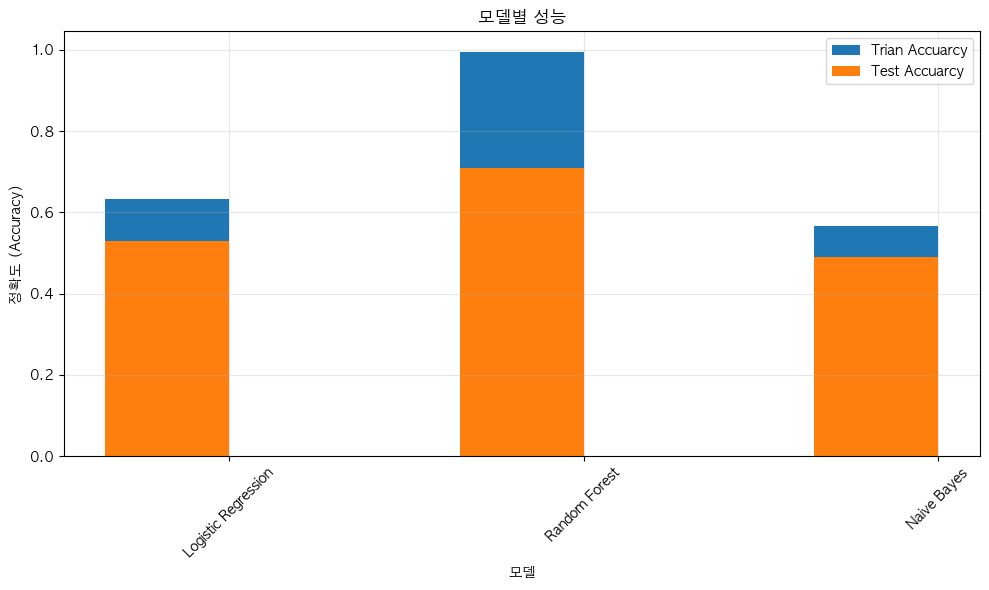

In [125]:
# 시각화
fig, ax = plt.subplots(figsize=(10, 6))

model_names = list(results.keys())  # keys() : 딕셔너리에서 key값만 뽑아낸다.
train_accs = [results[name]['train_acc'] for name in model_names]  # 학습 정확도 리스트
test_accs = [results[name]['test_acc'] for name in model_names]    # 테스트 정확도 리스트 

x = np.arange(len(model_names)) # x축 위치
width = 0.35                    # 막대 위치

ax.bar(
    x - width / 2,   # X축 위치는 왼쪽으로 width/2만큼 밀어준다.
    train_accs,      # 막대그래프의 y축으로 사용한다.
    width,           # 막대그래프의 두께
    label='Trian Accuarcy' # 막대그래프의 이름
)  # 학습 정확도 막대그래프
ax.bar(x - width / 2, test_accs, width, label='Test Accuarcy')   # 테스트 정확도 막대그래프

ax.set_xlabel("모델")
ax.set_ylabel("정확도 (Accuracy)")
ax.set_title("모델별 성능")
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45)  # X축 눈금(모델명)
ax.legend()  # 범례
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


랜덤포레스트는 성능은 가장 우수하였으나, 과적합   
나머지 모델들은 과소적합이다.

#### 모델 예측

In [126]:
# results[best_model_name]

In [127]:
# 가장 성능이 좋은 모델 선택
best_model_name = max(results, key=lambda x: results[x]['test_acc']) # 테스트 정확도가 가장 높은 모델
best_model = results[best_model_name]['model'] # 최고 모델 객체

print(f"최고 성능 모델 : {results[best_model_name]['model']}")
print(f"검증 정확도 : {results[best_model_name]['test_acc']:.4f}")
print(f"검증 f1-Score : {results[best_model_name]['test_f1']:.4f}")

# 검증 데이터에 대한 예측
if best_model_name == "Naive Bayes":
    y_test_pred = best_model['model'].predict(X_test_tfidf)              # 예측 레이블
    y_test_pred_proba = best_model['model'].predict_proba(X_test_tfidf)  # 클래스별 확률

else:
    y_test_pred = best_model.predict(X_test_combined)               # 예측 레이블
    y_test_pred_proba = best_model.predict_proba(X_test_combined)   # 클래스별 확률

# 예측 결과의 샘플 확인 (텍스트, 실제/예측 레이블, 신뢰도)
print("=== 예측 결과 샘플 ===")
for i in range(5):
    actual_label = label_encoder.inverse_transform([y_test.iloc[i]])[0]    # 실제 레이블 (문자형)으로 반환
    predicted_label = label_encoder.inverse_transform([y_test_pred[i]])[0] # 예측 레이블 (문자형)으로 반환
    confidence = y_test_pred_proba[i].max()

    print(f"샘플: {i+1}")
    print(f"텍스트: {test_df.iloc[i]['text_descriptions'][:50]}...")  # 텍스트 앞 50글자 미리보기
    print(f"실제 레이블: {actual_label}")
    print(f"예측 레이블: {predicted_label}")
    print(f"예측 신뢰도: {confidence:.3f}")


최고 성능 모델 : RandomForestClassifier(random_state=42)
검증 정확도 : 0.7087
검증 f1-Score : 0.7042
=== 예측 결과 샘플 ===
샘플: 1
텍스트: 가방 $80$개를 $4$개의 상자에 똑같이 나누어 담았습니다. 상자 한 개에 담은 가방은 ...
실제 레이블: 초등학교 3학년
예측 레이블: 초등학교 3학년
예측 신뢰도: 0.830
샘플: 2
텍스트: 학생 $120$명이 체육대회에 참여했습니다. $600$개의 장난감을 학생들에게 똑같이 나누...
실제 레이블: 초등학교 3학년
예측 레이블: 초등학교 3학년
예측 신뢰도: 0.660
샘플: 3
텍스트: 사탕 225개를 15개의 박스에 똑같이 나누어 담았습니다. 박스 한 개에 담은 사탕은 몇 ...
실제 레이블: 초등학교 3학년
예측 레이블: 초등학교 3학년
예측 신뢰도: 0.960
샘플: 4
텍스트: 도서관에 책 $270$권이 있습니다. 이 책을 $9$개의 책꽂이에 똑같이 나누어 놓으면, ...
실제 레이블: 초등학교 3학년
예측 레이블: 초등학교 3학년
예측 신뢰도: 0.890
샘플: 5
텍스트: 기차 8대에 320명의 승객이 탑승했습니다. 기차 한 대에 탑승한 승객은 몇 명일까요?...
실제 레이블: 초등학교 3학년
예측 레이블: 초등학교 3학년
예측 신뢰도: 0.720


#### 성능 지표 계산

In [128]:
test_accuracy = accuracy_score(y_test, y_test_pred) # 정확도
test_precision = precision_score(y_test, y_test_pred, average='weighted') # 정밀도
test_recall = recall_score(y_test, y_test_pred, average='weighted')       # 재현율(가중 평균)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')               # F1_score (가중 평균)

print(f"정확도 (Accuracy): {test_accuracy:.4f}")
print(f"정밀도 (Precision): {test_precision:.4f}")
print(f"재현율 (Recall): {test_recall:.4f}")
print(f"F1_score: {test_f1:.4f}")

정확도 (Accuracy): 0.7087
정밀도 (Precision): 0.7105
재현율 (Recall): 0.7087
F1_score: 0.7042


In [129]:
label_encoder.classes_

array(['고등학교 1학년', '중학교 1학년', '중학교 2학년', '중학교 3학년', '초등학교 3학년',
       '초등학교 4학년', '초등학교 5학년', '초등학교 6학년'], dtype=object)

In [130]:
print("===Classification Report===")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

===Classification Report===
              precision    recall  f1-score   support

    고등학교 1학년       0.58      0.54      0.56       119
     중학교 1학년       0.71      0.72      0.71       345
     중학교 2학년       0.86      0.80      0.83       357
     중학교 3학년       0.72      0.87      0.79       316
    초등학교 3학년       0.56      0.73      0.63       206
    초등학교 4학년       0.47      0.35      0.40       208
    초등학교 5학년       0.80      0.59      0.68       229
    초등학교 6학년       0.79      0.83      0.81       252

    accuracy                           0.71      2032
   macro avg       0.69      0.68      0.68      2032
weighted avg       0.71      0.71      0.70      2032



여기서 f1스코어가 낮은 초등학교 4학년은 이상치 처리를 더 해야될 것으로 보이고, 고등학교 1학년은 데이터를 증강시키는 방법을 쓰면 좋겠다.

In [131]:
class_report = classification_report(
    y_test, y_test_pred,                
    target_names=label_encoder.classes_,
    output_dict=True                     # 표 대신 딕셔너리로 변환 (그래프 등 후처리 작업시 편함)
)

class_report

{'고등학교 1학년': {'precision': 0.5818181818181818,
  'recall': 0.5378151260504201,
  'f1-score': 0.5589519650655022,
  'support': 119.0},
 '중학교 1학년': {'precision': 0.7138728323699421,
  'recall': 0.7159420289855073,
  'f1-score': 0.7149059334298119,
  'support': 345.0},
 '중학교 2학년': {'precision': 0.8558558558558559,
  'recall': 0.7983193277310925,
  'f1-score': 0.8260869565217391,
  'support': 357.0},
 '중학교 3학년': {'precision': 0.7161458333333334,
  'recall': 0.870253164556962,
  'f1-score': 0.7857142857142857,
  'support': 316.0},
 '초등학교 3학년': {'precision': 0.5571955719557196,
  'recall': 0.7330097087378641,
  'f1-score': 0.6331236897274634,
  'support': 206.0},
 '초등학교 4학년': {'precision': 0.474025974025974,
  'recall': 0.35096153846153844,
  'f1-score': 0.40331491712707185,
  'support': 208.0},
 '초등학교 5학년': {'precision': 0.8047337278106509,
  'recall': 0.5938864628820961,
  'f1-score': 0.6834170854271356,
  'support': 229.0},
 '초등학교 6학년': {'precision': 0.7886792452830189,
  'recall': 0.8293

- 혼동 행렬 시각화   
    - 혼동 행렬은 분류 모델 성능평가시 사용하는 오차 행렬   
    - 모델이 에측 결과와 실제값을 비교해서 얼마나 맞추고 틀렸는지를 정리해서 볼 수 있다.

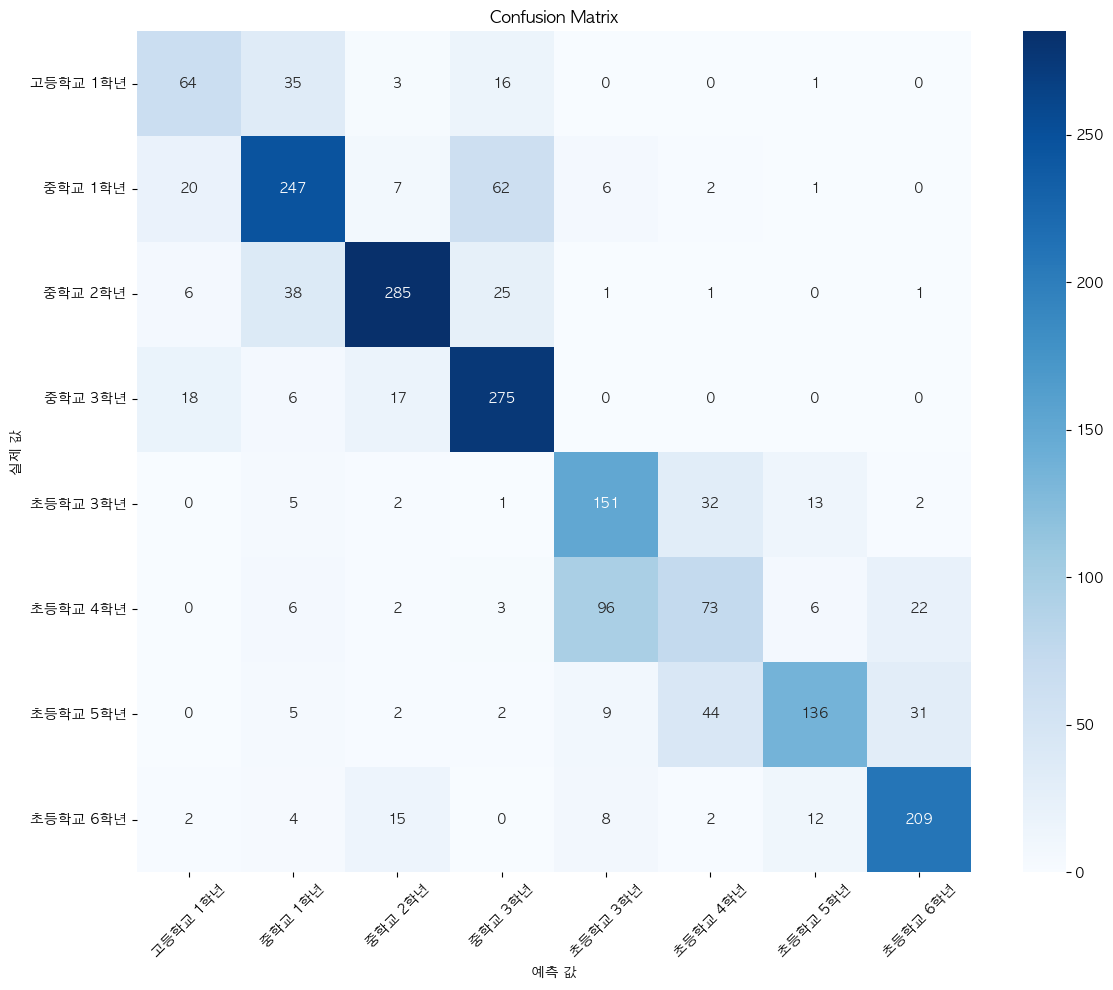

In [132]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,                                   # 혼동행렬 데이터
    annot = True,                         # 각 칸에 숫자 표시
    fmt = "d",                            # 정수형으로 포맷팅
    cmap = "Blues",                       # 컬러맵
    xticklabels = label_encoder.classes_, # x축 : 예측클래스 이름
    yticklabels = label_encoder.classes_  # y축 : 실제클래스 이름
)

plt.title('Confusion Matrix')
plt.xlabel('예측 값')
plt.ylabel('실제 값')
plt.xticks(rotation = 45)
plt.yticks(rotation = 0)
plt.tight_layout()
plt.show()

모델이 실제값과 예측값의 오차를 계산해보니 학교급 내에서의 구분이 어려웠다.   
파생변수를 좀 더 만들어도 되고, TF-IDF 특성을 조금 더 늘려봐도 되고, 데이터를 더 구해봐도 되고, ...

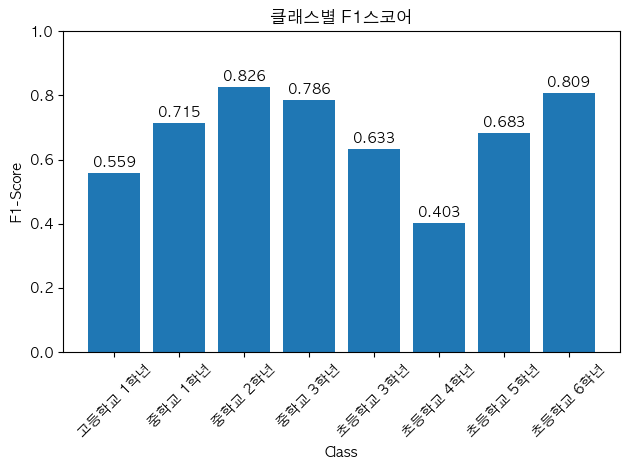

In [133]:
# 클래스별 성능 시각화
class_report = classification_report(
    y_test, y_test_pred,                
    target_names=label_encoder.classes_,
    output_dict=True                     # 표 대신 딕셔너리로 변환 (그래프 등 후처리 작업시 편함)
)

# f1-score만 추출 (정확도, 평균 제외)
class_f1_scores = {
    cls : metrics["f1-score"] for cls, metrics in class_report.items()  if cls not in ["accuracy", "macro avg", "weighted avg"]
}

classes = list(class_f1_scores.keys())
f1_scores = list(class_f1_scores.values())

# 막대그래프로 시각화
bars = plt.bar(classes, f1_scores)   # 막대그래프로 그리기
plt.xlabel("Class")
plt.ylabel("F1-Score")
plt.title("클래스별 F1스코어")
plt.xticks(rotation=45)
plt.ylim(0, 1.0)                     # y축 범위 (0~1)

# 각 막대 위에 값 표시
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x()+ bar.get_width() /2.0, # x축 위치 : 
        height + 0.03,
        f"{height:.3f}",
        ha ="center",
        va = "center"
    )

plt.tight_layout()
plt.show()

어떤 피처가 이 모델에서 중요성을 가지는지를 체크하면 성능을 조금 더 향상시킬 수 있다.   
   
- 모델 해석

   - 특성 중요도(Feature Importance) 분석

In [134]:
best_model.feature_importances_

array([0.00204693, 0.00018965, 0.0001728 , ..., 0.01379737, 0.01180167,
       0.01156207], shape=(1014,))

In [135]:
feature_importance = best_model.feature_importances_  # 특징 중요도 가져오기

tfidf_features = list(tfidf_vectorizer.get_feature_names_out()) # TF-IDF 특징 이름

additional_features = list(train_features.columns) # 추가 특징 이름

all_features = tfidf_features + additional_features # 전체 특징 이름

top_features_idx = feature_importance.argsort()[-20:][::-1]  # 상위 20개 중요 특징 (내림차순 정렬)
# feature_importance.argsort()[-20:][::-1]

for idx in top_features_idx:
    if idx < len(all_features):
        print(f"{all_features[idx]} : {feature_importance[idx]:.4f}")   # 특징명, 중요도

# 특징 유형별 중요도 합산 비교
tfidf_importance = feature_importance[:len(tfidf_features)].sum() # TF-IDF 중요도 합
additional_importance = feature_importance[len(tfidf_features):].sum() # 추가 특징 중요도 합

print()
print(f"TF-IDF 특징 중요도 : {tfidf_importance:.4f}")
print(f"추가 특징 중요도 : {additional_importance:.4f}")

text_length : 0.0293
avg_word_length : 0.0285
math_symbol_count : 0.0259
word_count : 0.0257
보세요 : 0.0233
num_count : 0.0215
다음 : 0.0195
선택하세요 : 0.0150
sentence_count : 0.0138
구하시오 : 0.0136
question_count : 0.0118
parenthesis_count : 0.0116
오른쪽 : 0.0108
sqrt : 0.0099
frac : 0.0083
일차함수 : 0.0076
has_calculation : 0.0076
계산하시오 : 0.0075
div : 0.0075
mathrm : 0.0069

TF-IDF 특징 중요도 : 0.8143
추가 특징 중요도 : 0.1857


질문의 길이, '보세요', '다음', '구하시오' 이러한 단어들이 유의미하게 판단하였다.   
14개로 수는 적었지만 추가 특징이 굉장히 판단할 때 유의미하게 기여하였다.

- 앙상블 모델 구축
    - VotingClassifier 사용한다.

In [136]:
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB

lr_for_ensemble = LogisticRegression(
    C = 10.0,         # 정규화는 약하게 
    max_iter = 1000,  # 반복횟수
    random_state = 42 # 시드고정, 재현성
)

rf_for_ensemble = RandomForestClassifier(
    n_estimators = 100,   # 트리 갯수
    random_state = 42
)

nb_for_ensemble = MultinomialNB()    # 다항 나이브베이즈

ensemble_model = VotingClassifier(
    estimators=[
        ('lr', lr_for_ensemble),  # 로지스틱 회귀
        ('rf', rf_for_ensemble),  # 랜덤포레스트
        ('nb', nb_for_ensemble)   # 나이브베이즈
    ],
    voting = 'soft' # 소프트보팅
)

ensemble_model.fit(X_train_combined, y_train)  # 모델 학습

ensemble_predictions = ensemble_model.predict(X_test_combined)  # 모델 예측

ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)               # 정확도
ensemble_f1_score = f1_score(y_test, ensemble_predictions, average='weighted') # 가중평균 사용 F1 스코어

print(f"정확도 : {ensemble_accuracy}")
print(f"F1 Score : {ensemble_f1_score}")

print("\n 개별 모델과 앙상블 모델 비교")
for name, result in results.items():
    print(f"{name} : {result['test_f1']:.4f}")
print(f"앙상블 모델 : {ensemble_f1_score:.4f}")

정확도 : 0.6313976377952756
F1 Score : 0.6283881079832863

 개별 모델과 앙상블 모델 비교
Logistic Regression : 0.5150
Random Forest : 0.7042
Naive Bayes : 0.4930
앙상블 모델 : 0.6284


앙상블을 한다고 해서 무조건 성능이 좋아지는 것은 아니다.

- Optuna로 DecisionTreeClassifier 하이퍼파라미터 최적화
    - GridSearchCV와 공통점 : 여러 파라미터 조합을 탐색
    - GridSearchCV와 차이점 : 매 Trial마다 파라미터를 똑똑하게 탐색/활용 추천해준다.
        - 그렇다고 성능이 무조건 좋은건 아니다 

In [137]:
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score           # Kfold로 사용, cv 점수 계산
from sklearn.tree import DecisionTreeClassifier                                     # 하이퍼파라미터 튜닝할 모델 (의사결정나무)
from sklearn.metrics import accuracy_score                                          # 정확도

# otuna가 한번 trial(시도) 할 때마다 하이퍼파라미터를 제안하는 범위를 지정한다.
# trial.suggest_ : optuna가 값을 뽑는 함수(GridSearchCV에서 "그리드" 역할)
def objective(trial):
    params = {
        'max_depth': trial.suggest_int("max_depth", 2, 10),                    # 트리 깊이: 2~10 중 선택
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),     # 분기 최소 샘플 수 : 2~10 중 선택
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1, 10),      # 리프 최소 샘플 수 : 1~10 중 선택
        'random_state' : 11                                                     # 재현성 (시드 고정)
    }
    
    model = DecisionTreeClassifier(**params)    # 모델 생성 (** (unpacking) : 딕셔너리 key=value 쌍을 펼쳐서 넣는다.)

    # 교차검증 실행 (StratifiedKFold : fold마다 클래스 비율을 유지. 불균형 데이터에 강하다.)
    cv = StratifiedKFold(
        n_splits=5              # 5등분
        , shuffle=True          # 데이터 랜덤으로 섞음
        , random_state=11       # 섞는 방식은 고정
    )

    # 학습 폴드로도 fit, 검증 폴드로는 predict, scorint기준으로 점수 계산. 5번 반복 후 점수 배열 반환
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

    return scores.mean()    # 평균 정확도를 반환. => Optuna가 최대화할 값 반환(평균 정확도가 높아지는 방향으로 파라미터를 잡는다.)

# Optuna 스터디 생성 (direction="maximize" : objective가 반환하는 값(정확도)를 최대화하도록 탐색)
study = optuna.create_study(direction="maximize")

# 최적화 수행
study.optimize(
    objective       # 함수(파라미터를 업데이트하는데 참고하는 함수)
    , n_trials=50   # 파라미터 조합 시도 수
)

# 탐색 결과 출력
print("Optuna 최적 하이퍼파라미터",study.best_params)
print(f"Optuna 교차검증 최고 정확도 : {study.best_value:.4f}")

# 최적 파라미터 적용 (best_params는 딕셔너리 형태이기 때문에 unpacking)
best_optuna_df = DecisionTreeClassifier(**study.best_params, random_state=11)
best_optuna_df.fit(X_train,y_train)

# 평가
optuna_pred = best_optuna_df.predict(X_test)            # 테스트 데이터 예측
optuna_acc = accuracy_score(y_test, optuna_pred)        # 테스트 정확도 계산
print(f"테스트셋으로 평가한 Optuna 튜닝 DecisionTreeClassifier 정확도 : {optuna_acc:.4f} ")

[I 2025-12-24 11:50:39,547] A new study created in memory with name: no-name-62a3b3ef-04b1-4319-9859-25696a5c16ef
[W 2025-12-24 11:50:39,548] Trial 0 failed with parameters: {'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 3} because of the following error: NameError("name 'X_train' is not defined").
Traceback (most recent call last):
  File "/opt/anaconda3/envs/ml_env/lib/python3.12/site-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/51/k_yn4qxs0_nfrm1hk39_0m2r0000gn/T/ipykernel_83694/804479229.py", line 26, in objective
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
                                    ^^^^^^^
NameError: name 'X_train' is not defined. Did you mean: 'y_train'?
[W 2025-12-24 11:50:39,549] Trial 0 failed with value None.


NameError: name 'X_train' is not defined